In [1]:
import numpy as np
import pandas as pd

from tqdm import tqdm
import pickle
import gc
import time

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import catboost as cb
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler 
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [2]:
def model_performance_sc_plot(predictions, labels, title):
    # Get min and max values of the predictions and labels.
    min_val = max(max(predictions), max(labels))
    max_val = min(min(predictions), min(labels))
    # Create dataframe with predicitons and labels.
    performance_df = pd.DataFrame({"Label":labels})
    performance_df["Prediction"] = predictions
    # Plot data
    sns.jointplot(y="Label", x="Prediction", data=performance_df, kind="reg", height=7)
    plt.plot([min_val, max_val], [min_val, max_val], 'm--')
    plt.title(title, fontsize=9)
    plt.show()

In [3]:
def exec_time(start_time):
    """Execution time in minutes"""
    return (time.time()-start_time)//60

# Train/test split

For a sake of the programming assignment, let's artificially split the data into train and test. We will treat last month data as the test set.

In [4]:
# Will we save intermediate models?
save_models = True

In [5]:
all_data = pd.read_parquet('data/all_data.parquet')
# print('Columns:', all_data.columns)
print('all_data coulumns =', list(all_data.columns))
all_data.info()
all_data

all_data coulumns = ['shop_id', 'item_id', 'date_block_num', 'item_category_id', 'target', 'target_shop_date', 'target_item_date', 'target_item_shop_date', 'target_item-cat_date', 'target_shop_item-cat_date', 'target_mean', 'target_shop_date_mean', 'target_item_date_mean', 'target_item_shop_date_mean', 'target_item-cat_date_mean', 'target_shop_item-cat_date_mean', 'target_lag_1', 'target_item-cat_date_lag_1', 'target_item-cat_date_mean_lag_1', 'target_item_date_lag_1', 'target_item_date_mean_lag_1', 'target_item_shop_date_lag_1', 'target_item_shop_date_mean_lag_1', 'target_mean_lag_1', 'target_shop_date_lag_1', 'target_shop_date_mean_lag_1', 'target_shop_item-cat_date_lag_1', 'target_shop_item-cat_date_mean_lag_1', 'target_lag_2', 'target_item-cat_date_lag_2', 'target_item-cat_date_mean_lag_2', 'target_item_date_lag_2', 'target_item_date_mean_lag_2', 'target_item_shop_date_lag_2', 'target_item_shop_date_mean_lag_2', 'target_mean_lag_2', 'target_shop_date_lag_2', 'target_shop_date_mean_

,shop_id,item_id,date_block_num,item_category_id,target,target_shop_date,target_item_date,target_item_shop_date,target_item-cat_date,target_shop_item-cat_date,...,target_shop_item-cat_date_lag_12,target_shop_item-cat_date_mean_lag_12,city_code,type_code,subtype_code,month_num,item_first_sale,item_shop_first_sale,days,delta_price_lag
0,59,944,12,37,1.0,1491.0,23.0,1.0,7511.0,104.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
1,59,21861,12,37,1.0,1491.0,62.0,1.0,7511.0,104.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
2,59,21455,12,37,1.0,1491.0,20.0,1.0,7511.0,104.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
3,59,33,12,37,2.0,1491.0,42.0,2.0,7511.0,104.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
4,59,19750,12,37,1.0,1491.0,8.0,1.0,7511.0,104.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6639289,45,18454,34,55,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,20,13,2,10,11,11,30,-0.475305
6639290,45,16188,34,64,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,20,14,42,10,2,2,30,0.081167
6639291,45,15757,34,55,0.0,0.0,0.0,0.0,0.0,0.0,...,124.0,124.0,20,13,2,10,22,22,30,0.155905
6639292,45,19648,34,40,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,20,11,4,10,11,11,30,-0.091709


In [6]:
# list(all_data.columns)

In [7]:
# List of all lagged features

# We will drop these at fitting stage
to_drop_cols = ['target_shop_date', 'target_item_shop_date_mean', 'target_shop_item-cat_date_mean', 'target_shop_item-cat_date', 
                'target_item_date_mean', 'target_item-cat_date_mean', 'target_item-cat_date', 'target_item_shop_date', 
                'target_item_date', 'target', 'target_shop_date_mean', 'target_mean', 'date_block_num']

# Categorical features
cat_features = ['shop_id', 'item_id', 'item_category_id', 'city_code', 
                'type_code', 'subtype_code']

In [8]:
# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
dates = all_data['date_block_num']

last_block = dates.max()-1
print('Test `date_block_num` is %d' % last_block)

Test `date_block_num` is 33


In [9]:
train_width = 3 # number of month in the train set

train_if = dates<=(last_block-train_width)
test_if = (dates<=last_block)&(dates>(last_block-train_width))

dates_train = dates[train_if]
dates_test  = dates[test_if]

X_train =  all_data.loc[train_if].drop(to_drop_cols, axis=1)
X_test =   all_data.loc[test_if].drop(to_drop_cols, axis=1)
X_target = all_data.loc[dates == dates.max()].drop(to_drop_cols, axis=1)

y_train = all_data.loc[train_if, 'target'].values
y_test =  all_data.loc[test_if, 'target'].values

In [10]:
X_train

,shop_id,item_id,item_category_id,target_lag_1,target_item-cat_date_lag_1,target_item-cat_date_mean_lag_1,target_item_date_lag_1,target_item_date_mean_lag_1,target_item_shop_date_lag_1,target_item_shop_date_mean_lag_1,...,target_shop_item-cat_date_lag_12,target_shop_item-cat_date_mean_lag_12,city_code,type_code,subtype_code,month_num,item_first_sale,item_shop_first_sale,days,delta_price_lag
0,59,944,37,0.0,9959.0,9959.0,24.0,24.0,0.0,0.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
1,59,21861,37,0.0,9959.0,9959.0,28.0,28.0,0.0,0.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
2,59,21455,37,1.0,9959.0,9959.0,12.0,12.0,1.0,1.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
3,59,33,37,0.0,9959.0,9959.0,42.0,42.0,0.0,0.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
4,59,19750,37,0.0,9959.0,9959.0,15.0,15.0,0.0,0.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5972381,55,13099,34,20.0,347.0,347.0,71.0,71.0,71.0,71.0,...,0.0,0.0,27,9,6,5,9,9,30,0.000000
5972382,55,13098,34,20.0,347.0,347.0,58.0,58.0,58.0,58.0,...,0.0,0.0,27,9,6,5,9,9,30,0.000000
5972383,55,5230,26,6.0,15.0,15.0,6.0,6.0,6.0,6.0,...,0.0,0.0,27,6,61,5,6,6,30,0.058935
5972384,55,2757,26,7.0,15.0,15.0,7.0,7.0,7.0,7.0,...,0.0,0.0,27,6,61,5,6,6,30,-0.031505


In [11]:
# del all_data
gc.collect()

44

# First level models 

You need to implement a basic stacking scheme. We have a time component here, so we will use ***scheme f)*** from the reading material. Recall, that we always use first level models to build two datasets: test meta-features and 2-nd level train-metafetures. Let's see how we get test meta-features first. 

### Test meta-features

Firts, we will run *linear regression* on numeric columns and get predictions for the last month.

In [12]:
cat_columns = ['shop_id', 'item_id', 'item_category_id', 'city_code', 'type_code', 'subtype_code']

print('cat_features =', cat_features)
print('cat_columns =', cat_columns)
for cat in cat_columns:
    print('for category ', cat, 'found unique values:', X_train[cat].unique().shape[0])

cat_features = ['shop_id', 'item_id', 'item_category_id', 'city_code', 'type_code', 'subtype_code']
cat_columns = ['shop_id', 'item_id', 'item_category_id', 'city_code', 'type_code', 'subtype_code']
for category  shop_id found unique values: 54
for category  item_id found unique values: 15959
for category  item_category_id found unique values: 78
for category  city_code found unique values: 31
for category  type_code found unique values: 19
for category  subtype_code found unique values: 61


In [13]:
%%time
# Linear regresson
model_lr = make_pipeline(
    #OneHotEncoder(),
    MinMaxScaler(),
    LinearRegression(n_jobs=-1),
    verbose=True,
)
model_lr.fit(X_train, y_train)
pred_lr = model_lr.predict(X_test)

print('\nTest R-squared for linreg is %f' % r2_score(y_test, pred_lr))
print('Test RMSE linreg is %f' % np.sqrt(mean_squared_error(y_test, pred_lr)))

if save_models:
    pickle.dump(model_lr, open('data/sa-model_lr.pkl', "wb"))

[Pipeline] ...... (step 1 of 2) Processing minmaxscaler, total=   3.2s
[Pipeline] .. (step 2 of 2) Processing linearregression, total=  28.0s

Test R-squared for linreg is 0.331656
Test RMSE linreg is 0.915047
CPU times: user 1min 4s, sys: 8.59 s, total: 1min 13s
Wall time: 31.5 s


In [14]:
#model_performance_sc_plot(pred_kr, y_test, 'Test')

In [15]:
%%time
from sklearn.neural_network import MLPRegressor

model_mlp = make_pipeline(
    MinMaxScaler(),
    MLPRegressor(
        random_state=47, 
        verbose=True,
        early_stopping=True,
        n_iter_no_change=5,
        solver='adam',
#         hidden_layer_sizes=(300, 200 ,100), alpha=0.03, learning_rate='adaptive', learning_rate_init=0.0005, 
#         max_iter=200, momentum=0.9, nesterovs_momentum=True,
    ),
    verbose=True,
)
model_mlp.fit(X_train, y_train)
pred_mlp = model_mlp.predict(X_test)
train_mlp = model_mlp.predict(X_train)

print('Test R-squared is %f' % r2_score(y_test, pred_mlp))
print('Train R-squared is %f' % r2_score(y_train, train_mlp))
print(f'Test RMSE is {np.sqrt(mean_squared_error(y_test, pred_mlp)):.6}')
print(f'Train RMSE is {np.sqrt(mean_squared_error(y_train, train_mlp)):.6}')

if save_models:
    pickle.dump(model_mlp, open('data/sa-model_mlp.pkl', "wb"))

[Pipeline] ...... (step 1 of 2) Processing minmaxscaler, total=   3.2s
Iteration 1, loss = 0.40942384
Validation score: 0.445419
Iteration 2, loss = 0.39461694
Validation score: 0.457935
Iteration 3, loss = 0.38811967
Validation score: 0.463659
Iteration 4, loss = 0.38352595
Validation score: 0.466277
Iteration 5, loss = 0.38004801
Validation score: 0.470572
Iteration 6, loss = 0.37758093
Validation score: 0.477570
Iteration 7, loss = 0.37560011
Validation score: 0.474676
Iteration 8, loss = 0.37409476
Validation score: 0.476688
Iteration 9, loss = 0.37283354
Validation score: 0.475768
Iteration 10, loss = 0.37192849
Validation score: 0.479780
Iteration 11, loss = 0.37102853
Validation score: 0.483386
Iteration 12, loss = 0.37041862
Validation score: 0.484019
Iteration 13, loss = 0.36958855
Validation score: 0.483125
Iteration 14, loss = 0.36911309
Validation score: 0.482063
Iteration 15, loss = 0.36873043
Validation score: 0.485853
Iteration 16, loss = 0.36823003
Validation score: 0.4

In [16]:
%%time
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import BayesianRidge
# linear_features = ['target_item_date_lag_1', 'delta_price_lag', 
#                 'target_lag_1', 'target_lag_2', 'item_category_id',  'target_mean_lag_1',
#                 'target_mean_lag_2',
#                 'target_item_date_mean_lag_1', 'target_item_date_mean_lag_2',  
#                 'target_item_shop_date_lag_1', 'target_item_shop_date_lag_2',
#                'target_shop_date_mean_lag_1']
# linear_features = ['target_lag_1', 'target_item-cat_date_lag_1', 'target_item-cat_date_mean_lag_1', 
#                    'target_item_date_lag_1', 'target_item_date_mean_lag_1', 'target_item_shop_date_lag_1', 
#                    'target_item_shop_date_mean_lag_1', 'target_mean_lag_1', 'target_shop_date_lag_1', 
#                    'target_shop_date_mean_lag_1', 'target_shop_item-cat_date_lag_1', 'target_shop_item-cat_date_mean_lag_1', 
#                    'target_lag_2', 'target_item-cat_date_lag_2', 'target_item-cat_date_mean_lag_2', 'target_item_date_lag_2', 
#                    'target_item_date_mean_lag_2', 'target_item_shop_date_lag_2', 'target_item_shop_date_mean_lag_2', 
#                    'target_mean_lag_2', 'target_shop_date_lag_2', 'target_shop_date_mean_lag_2', 'target_shop_item-cat_date_lag_2', 
#                    'target_shop_item-cat_date_mean_lag_2']

linear_features = ['target_lag_1', 'target_item-cat_date_mean_lag_1', 
                   'target_item_date_mean_lag_1', 
                   'target_item_shop_date_mean_lag_1', 'target_mean_lag_1',
                   'target_shop_date_mean_lag_1', 'target_shop_item-cat_date_mean_lag_1', 
                   'target_lag_2', 'target_item-cat_date_mean_lag_2', 
                   'target_item_date_mean_lag_2', 'target_item_shop_date_mean_lag_2', 
                   'target_mean_lag_2', 'target_shop_date_mean_lag_2', 
                   'target_shop_item-cat_date_mean_lag_2',
                   'target_lag_3', 'target_item-cat_date_mean_lag_3', 'target_item_date_mean_lag_3', 
                   'target_item_shop_date_mean_lag_3', 'target_mean_lag_3', 'target_shop_date_mean_lag_3', 
                   'target_shop_item-cat_date_mean_lag_3',
                   'days', 'delta_price_lag']



model_lrc = make_pipeline(
    ColumnTransformer([
         ('one_hot_item_category_id', OneHotEncoder(), ['item_category_id']),
         ('one_hot_city_code', OneHotEncoder(), ['city_code']),
         ('one_hot_type_code', OneHotEncoder(), ['type_code']),
         ('to_pass', 'passthrough', linear_features)
        ], remainder='drop', n_jobs=-1, 
        sparse_threshold=0.3,
        verbose=True),
    MaxAbsScaler(),
    LinearRegression(n_jobs=-1),
    #ElasticNetCV(n_jobs=-1, random_state=43, max_iter=1000),
    #BayesianRidge(),
    verbose=True,
)
model_lrc.fit(X_train, y_train)
pred_lrc = model_lrc.predict(X_test)

print('\nTest R-squared for linreg is %f' % r2_score(y_test, pred_lrc))
print('Test RMSE linreg is %f' % np.sqrt(mean_squared_error(y_test, pred_lrc)))

if save_models:
    pickle.dump(model_lrc, open('data/sa-model_lrc.pkl', "wb"))

[Pipeline] . (step 1 of 3) Processing columntransformer, total=   8.7s
[Pipeline] ...... (step 2 of 3) Processing maxabsscaler, total=   3.1s
[Pipeline] .. (step 3 of 3) Processing linearregression, total= 2.5min


ValueError: Found unknown categories [36] in column 0 during transform

In [17]:
%%time
# BayesianRidge regression
ts=time.time()
from sklearn.linear_model import BayesianRidge

model_br = make_pipeline(
    MinMaxScaler(), 
    BayesianRidge() #n_iter=1000, tol=0.0001)
)

model_br.fit(X_train, y_train)
pred_br = model_br.predict(X_test)

print(f'Test BayesianRidge linreg is {np.sqrt(mean_squared_error(y_test, pred_br)):.6f}' )

if save_models:
    pickle.dump(model_br, open('data/sa-model_br.pkl', "wb"))
exec_time(ts)

Test BayesianRidge linreg is 0.915050
CPU times: user 1min 56s, sys: 15.8 s, total: 2min 11s
Wall time: 49.2 s


0.0

In [18]:
%%time
# ElasticNetCV
from sklearn.linear_model import ElasticNetCV

model_en = make_pipeline(
    StandardScaler(), 
    ElasticNetCV(n_jobs=-1, random_state=43, max_iter=1000)
)
model_en.fit(X_train.values, y_train)
pred_en = model_en.predict(X_test.values)

print('Test ElasticNet linreg is %f' % np.sqrt(mean_squared_error(y_test, pred_en)))

if save_models:
    pickle.dump(model_en, open('data/sa-model_en.pkl', "wb"))

Test ElasticNet linreg is 0.916715
CPU times: user 5min 47s, sys: 1min 8s, total: 6min 56s
Wall time: 2min 55s


In [19]:
%%time
# LassoCV
from sklearn.linear_model import LassoCV

model_lcv =  make_pipeline(
    StandardScaler(),
    LassoCV(n_jobs=4, random_state=43)
)
model_lcv.fit(X_train.values, y_train)
pred_lcv = model_lcv.predict(X_test.values)

print('Test LassoCV is %f' % np.sqrt(mean_squared_error(y_test, pred_lcv)))

if save_models:
    pickle.dump(model_lcv, open('data/sa-model_lcv.pkl', "wb"))

Test LassoCV is 0.916895
CPU times: user 2min 4s, sys: 33.7 s, total: 2min 37s
Wall time: 2min 10s


In [20]:
%%time
# RidgeCV
from sklearn.linear_model import RidgeCV

model_rcv =  make_pipeline(
    StandardScaler(),
    RidgeCV(scoring='neg_mean_squared_error')
)
model_rcv.fit(X_train.values, y_train)
pred_rcv = model_rcv.predict(X_test.values)

print('Test RidgeCV is %f' % np.sqrt(mean_squared_error(y_test, pred_rcv)))

if save_models:
    pickle.dump(model_rcv, open('data/sa-model_rcv.pkl', "wb"))

Test RidgeCV is 0.915050
CPU times: user 2min 5s, sys: 20 s, total: 2min 25s
Wall time: 1min 19s


## Tree-based models

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 0.851711
[200]	valid_0's l2: 0.782277
[300]	valid_0's l2: 0.761151
[400]	valid_0's l2: 0.751218
[500]	valid_0's l2: 0.745931
[600]	valid_0's l2: 0.742252
[700]	valid_0's l2: 0.740405
[800]	valid_0's l2: 0.738005
[900]	valid_0's l2: 0.736553
[1000]	valid_0's l2: 0.734752
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.734752

Test R-squared for LightGBM is 0.413519
Test RMSE LightGBM is 0.857177

CPU times: user 24min 43s, sys: 16.2 s, total: 25min
Wall time: 7min 19s


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

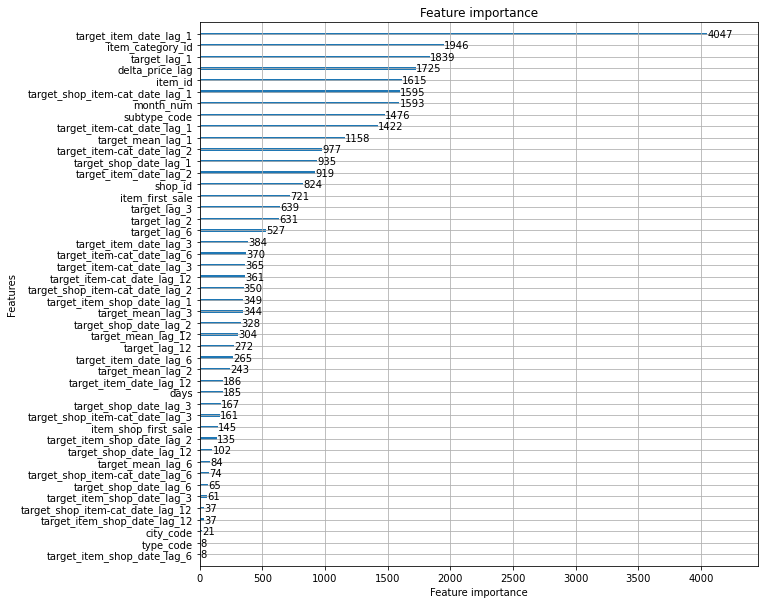

In [21]:
%%time
# LightGBM
model_lgb = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=10,
    #num_leaves=60,
    n_jobs=-1,
    objective='mse',
    random_state=43
)

model_lgb.fit(
    X_train, y_train, 
    eval_set=(X_test, y_test), 
    early_stopping_rounds=100,
    verbose=100
)
pred_lgb = model_lgb.predict(X_test)

print('\nTest R-squared for LightGBM is %f' % r2_score(y_test, pred_lgb))
print('Test RMSE LightGBM is %f' % np.sqrt(mean_squared_error(y_test, pred_lgb)))
print()

# Save model to disk
if save_models:
    pickle.dump(model_lgb, open('data/sa-model_lgb.pkl', "wb"))

# Plot LightGBM features importance
fig, ax = plt.subplots(1,1,figsize=(10, 10))
lgb.plot_importance(booster=model_lgb, ax=ax)

In [22]:
#model_lgb.get_params()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.236656
0:	learn: 1.0969229	test: 1.0485189	best: 1.0485189 (0)	total: 1.22s	remaining: 20m 22s
10:	learn: 0.8896251	test: 0.8879166	best: 0.8879166 (10)	total: 13.6s	remaining: 20m 18s
20:	learn: 0.8681885	test: 0.8758174	best: 0.8758174 (20)	total: 27.7s	remaining: 21m 32s
30:	learn: 0.8517389	test: 0.8703952	best: 0.8702976 (27)	total: 42.1s	remaining: 21m 57s
40:	learn: 0.8414696	test: 0.8661601	best: 0.8661554 (38)	total: 55.8s	remaining: 21m 44s
50:	learn: 0.8352437	test: 0.8646346	best: 0.8645074 (49)	total: 1m 9s	remaining: 21m 32s
60:	learn: 0.8262790	test: 0.8607753	best: 0.8607753 (60)	total: 1m 22s	remaining: 21m 12s
70:	learn: 0.8212883	test: 0.8590645	best: 0.8590645 (70)	total: 1m 37s	remaining: 21m 13s
80:	learn: 0.8172195	test: 0.8578789	best: 0.8578789 (80)	total: 1m 51s	remaining: 21m 6s
90:	learn: 0.8130996	test: 0.8558815	best: 0.8558815 (90)	total: 2m 4s	remaining: 20m 43s
100:	learn: 0.8098095	test: 0.8550236	best: 0.8550236 (100)	total: 2m 

<AxesSubplot:title={'center':'Feature importances'}, ylabel='Feature Id'>

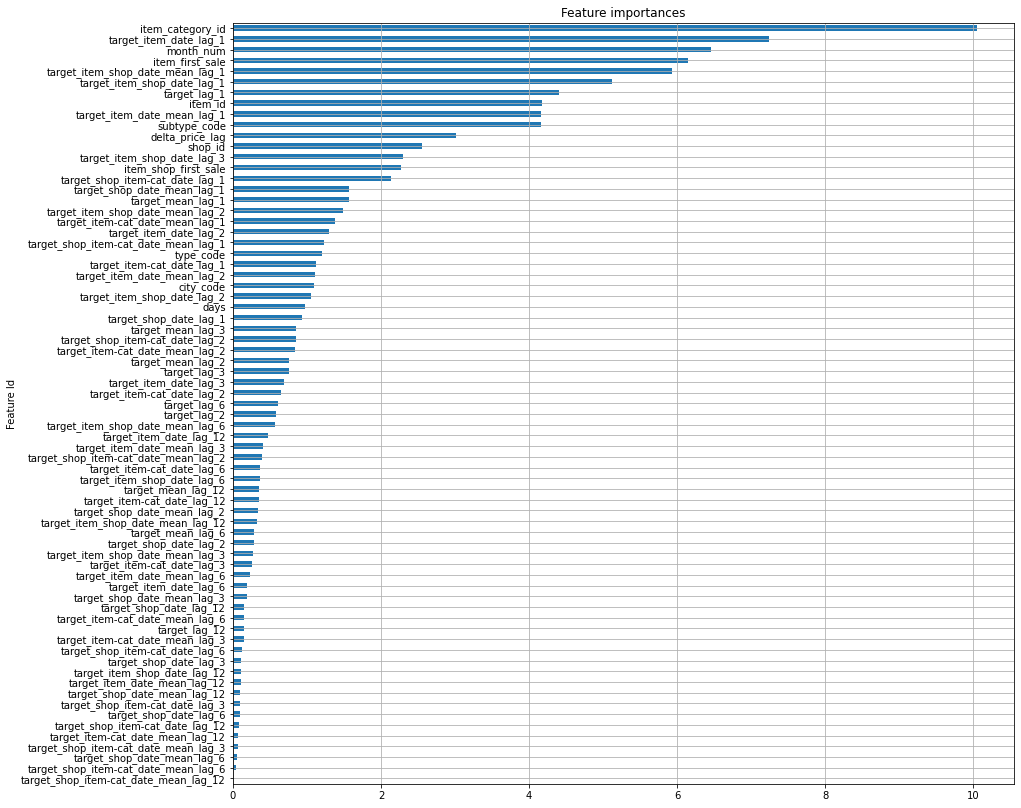

In [23]:
%%time
# Catboost

model_cbr = cb.CatBoostRegressor(
    loss_function='RMSE',
    #cat_features=cat_features,
    #l2_leaf_reg=6,
    depth=8,
    #learning_rate=0.1,
    #iterations=10000,
    iterations=1000,
    task_type='CPU',
    random_state=43,
)
model_cbr.fit(
    X_train, y_train, 
    eval_set=(X_test, y_test), 
    verbose=10, 
    #early_stopping_rounds=500,
    early_stopping_rounds=30,
    plot=True,
)
pred_cb = model_cbr.predict(X_test)

print('\nTest R-squared for CatBoost is %f' % r2_score(y_test, pred_cb))
print('Test RMSE CatBoost is %f' % np.sqrt(mean_squared_error(y_test, pred_cb)))
print()

# Save model to disk
if save_models:
    pickle.dump(model_cbr, open('data/sa-model_cbr.pkl', "wb"))

# Plot CatBoost features importance
f_importance = model_cbr.get_feature_importance(prettified=True)
f_importance[f_importance['Importances']>0].sort_values(by='Importances', ascending=True).set_index('Feature Id').plot(
    kind='barh', figsize=(14,14), legend=False, grid=True, title="Feature importances");

In [24]:
# model_cbr.get_all_params()

[22:07:23] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.06150	validation_1-rmse:1.02355
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[5]	validation_0-rmse:0.87209	validation_1-rmse:0.87855
[10]	validation_0-rmse:0.84514	validation_1-rmse:0.86224
[15]	validation_0-rmse:0.83282	validation_1-rmse:0.85895
[20]	validation_0-rmse:0.82653	validation_1-rmse:0.85588
[25]	validation_0-rmse:0.81965	validation_1-rmse:0.85241
[30]	validation_0-rmse:0.81628	validation_1-rmse:0.85184
[35]	validation_0-rmse:0.81211	validation_1-rmse:0.85096
[40]	validation_0-rmse:0.80870	validation_1-rmse:0.84953
[45]	validation_0-rmse:0.80502	validation_1-rmse:0.847

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

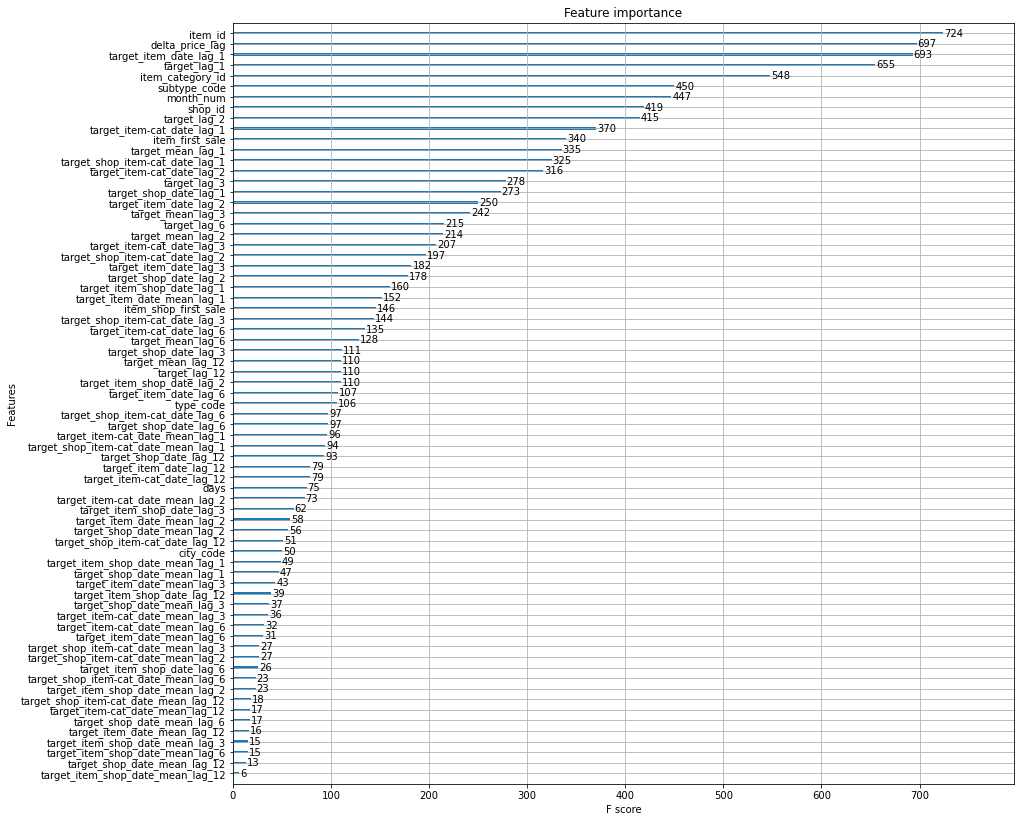

In [25]:
%%time
# xgboost
model_xgb = xgb.XGBRegressor(
    n_jobs=4, 
    random_state=43,
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,
)

model_xgb.fit(
    X_train, y_train, 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    eval_metric="rmse", 
    verbose=5, 
    early_stopping_rounds = 20
)
pred_xgb = model_xgb.predict(X_test)

print('\nTest R-squared for XGBoost is %f' % r2_score(y_test, pred_xgb))
print('Test RMSE XGBoost is %f' % np.sqrt(mean_squared_error(y_test, pred_xgb)))
print()

# Save model to disk
if save_models:
    pickle.dump(model_xgb, open('data/sa-model_xgb.pkl', "wb"))

# Plot XGBoost features importance
fig, ax = plt.subplots(1,1,figsize=(14, 14))
xgb.plot_importance(booster=model_xgb, ax=ax)

In [26]:
%%time
# RandomForest
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor(
    criterion='mse',
    n_jobs=-1,
    n_estimators=50, 
    max_depth=8,
    random_state=47,
    verbose=10,
)

model_rf.fit(
    X_train, y_train, 
)
pred_rf = model_rf.predict(X_test)

print('\nTest R-squared for RandomForestRegressor is %f' % r2_score(y_test, pred_rf))
print('Test RMSE XGBoost is %f' % np.sqrt(mean_squared_error(y_test, pred_rf)))
print()

# Save model to disk
if save_models:
    pickle.dump(model_rf, open('data/sa-model_rf.pkl', "wb"))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 50
building tree 2 of 50building tree 3 of 50

building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  3.7min


building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  5.6min


building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  9.3min


building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 11.4min


building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 16.9min


building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 20.7min


building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 24.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.2s



Test R-squared for RandomForestRegressor is 0.372671
Test RMSE XGBoost is 0.886526

CPU times: user 1h 15min 51s, sys: 39.1 s, total: 1h 16min 30s
Wall time: 24min 2s


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.3s finished


In [27]:
%%time
# KNeighborsRegressor
from sklearn.neighbors import KNeighborsRegressor
knn_features = ['target_item_date_lag_1', 'delta_price_lag', 
                'target_lag_1', 'target_lag_2', 'item_category_id', 'subtype_code', 'target_mean_lag_1',
                'target_item_date_mean_lag_1',  'target_item_shop_date_lag_1',
               'target_shop_date_mean_lag_1']

# Subsample train set (using the whole data was taking too long).
X_train_sampled = X_train[:400000]
y_train_sampled = y_train[:400000]

model_knr =  make_pipeline(
    ColumnTransformer([
         ('to_pass', 'passthrough', knn_features)
        ], remainder='drop', n_jobs=-1, verbose=True),
    MinMaxScaler(),
    KNeighborsRegressor(algorithm='auto', leaf_size=13, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
          weights='uniform')
)
model_knr.fit(X_train_sampled, y_train_sampled)
print('Model fitting done')
pred_knr = model_knr.predict(X_test)

print(f'Test KNeighborsRegressor is {np.sqrt(mean_squared_error(y_test, pred_knr)):.6f}')

if save_models:
    pickle.dump(model_knr, open('data/sa-model_knr.pkl', "wb"))

Model fitting done
Test KNeighborsRegressor is 0.951707
CPU times: user 6min 9s, sys: 2.23 s, total: 6min 11s
Wall time: 4min 10s


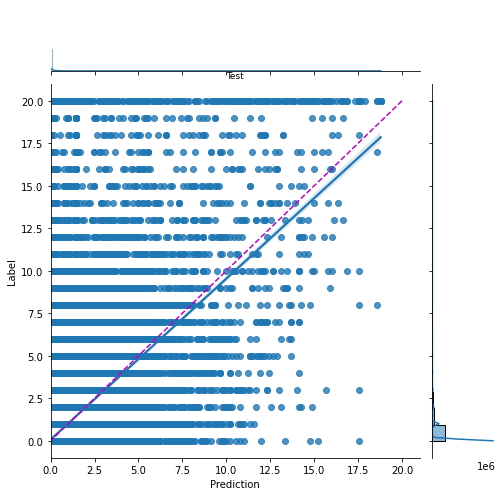

In [28]:
model_performance_sc_plot(pred_knr, y_test, 'Test')

## Load pickled predictors 

In [29]:
# Load pickled predictors
if save_models:
    model_lr   = pickle.load(open('data/sa-model_lr.pkl', "rb"))    # LinearRegression
    model_lgb  = pickle.load(open('data/sa-model_lgb.pkl', "rb"))   # LightGBM
    model_cbr  = pickle.load(open('data/sa-model_cbr.pkl', "rb"))   # CatBoost
    model_xgb  = pickle.load(open('data/sa-model_xgb.pkl', "rb"))   # xgboost
    model_br   = pickle.load(open('data/sa-model_br.pkl', "rb"))    # BayesianRidge
    model_sgdr = pickle.load(open('data/sa-model_sgdr.pkl', "rb"))  # SGDRegressor (decrease quality)
    model_en   = pickle.load(open('data/sa-model_en.pkl', "rb"))    # ElasticNetCV

In [30]:
%%time
# Make predictions for test data
train_lr  = model_lr.predict(X_train)
train_lgb = model_lgb.predict(X_train)
train_cbr = model_cbr.predict(X_train)
train_xgb = model_xgb.predict(X_train)
train_br  = model_br.predict(X_train)
# train_sgdr= model_sgdr.predict(X_train)
train_en  = model_en.predict(X_train)

X_train_level2 = np.c_[train_lr, train_lgb, train_cbr, train_xgb, train_br, train_en] 
# X_train_level2 = np.c_[train_lr, train_cbr, train_xgb] 
# X_test_level2.tofile('X_test_level2')
print('Train L2 data shape:', X_train_level2.shape)

Train L2 data shape: (5753731, 6)
CPU times: user 6min 44s, sys: 7.75 s, total: 6min 52s
Wall time: 2min 11s


In [31]:
%%time
# Make predictions for test data (Kaggle's test dataset)
test_lr  = model_lr.predict(X_test)
test_lgb = model_lgb.predict(X_test)
test_cbr = model_cbr.predict(X_test)
test_xgb = model_xgb.predict(X_test)
test_br  = model_br.predict(X_test)
# test_sgdr= model_sgdr.predict(X_test)
test_en  = model_en.predict(X_test)

X_test_level2 = np.c_[test_lr, test_lgb, test_cbr, test_xgb, test_br, test_en]
# X_test_level2 = np.c_[test_lr, test_cbr, test_xgb]
print('Test L2 data shape:', X_test_level2.shape)

Test L2 data shape: (671363, 6)
CPU times: user 48.7 s, sys: 1.14 s, total: 49.8 s
Wall time: 16.1 s


In [32]:
%%time
# Make prediction for target data
target_lr  = model_lr.predict(X_target)
target_lgb = model_lgb.predict(X_target)
target_cbr = model_cbr.predict(X_target)
target_xgb = model_xgb.predict(X_target)
target_br  = model_br.predict(X_target)
# target_sgdr= model_sgdr.predict(X_target)
target_en  = model_en.predict(X_target)

X_target_level2 = np.c_[target_lr, target_lgb, target_cbr, target_xgb, target_br, target_en]
# X_target_level2 = np.c_[target_lr, target_cbr, target_xgb]
print('Target L2 data shape:', X_target_level2.shape)

Target L2 data shape: (214200, 6)
CPU times: user 17.2 s, sys: 712 ms, total: 17.9 s
Wall time: 7.34 s


# Let's make L2 predictions

In [33]:
%%time
l2_model_lr = LinearRegression()
l2_model_lr.fit(X_train_level2, y_train)
test_l2_lr = l2_model_lr.predict(X_test_level2)

print(f'Test RMSE for LinearRegression L2 is {np.sqrt(mean_squared_error(y_test, test_l2_lr)):.6f}')

Test RMSE for LinearRegression L2 is 0.844644
CPU times: user 1.17 s, sys: 434 ms, total: 1.6 s
Wall time: 835 ms


In [34]:
from sklearn.linear_model import ElasticNetCV
l2_model_en = ElasticNetCV()
l2_model_en.fit(X_train_level2, y_train)
test_l2_en = l2_model_en.predict(X_test_level2)

print(f'Test RMSE for ElasticNet L2 is {np.sqrt(mean_squared_error(y_test, test_l2_en)):.6f}')

Test RMSE for ElasticNet L2 is 0.843572


In [35]:
%%time
# BayesianRidge regression
from sklearn.linear_model import BayesianRidge
l2_model_br = BayesianRidge()
l2_model_br.fit(X_train_level2, y_train)
test_l2_br = l2_model_br.predict(X_test_level2)

# print('Test R-squared for linreg is %f' % r2_score(y_test, pred_lr))
print('Test BayesianRidge L2 is %f' % np.sqrt(mean_squared_error(y_test, test_l2_br)))

Test BayesianRidge L2 is 0.844640
CPU times: user 4.01 s, sys: 1.4 s, total: 5.41 s
Wall time: 1.99 s


In [36]:
%%time
# LassoCV
from sklearn.linear_model import LassoCV

l2_model_lcv = LassoCV(n_jobs=4, random_state=43)

l2_model_lcv.fit(X_train_level2, y_train)
test_l2_lcv = l2_model_lcv.predict(X_test_level2)

print('Test LassoCV L2 is %f' % np.sqrt(mean_squared_error(y_test, test_l2_lcv)))

Test LassoCV L2 is 0.844038
CPU times: user 2min 11s, sys: 21.4 s, total: 2min 33s
Wall time: 51.6 s


In [37]:
%%time
l2_model_cb = cb.CatBoostRegressor(
    loss_function='RMSE',
    task_type='CPU',
    #depth=8,
    #learning_rate=0.001,
    #l2_leaf_reg=6,
)
l2_model_cb.fit(X_train_level2, y=y_train,
                eval_set=(X_test_level2, y_test),
                early_stopping_rounds=20,
                verbose=20,
                use_best_model=True,
                plot=True)
test_l2_cbr = l2_model_cb.predict(X_test_level2)

print()
print(f'Test RMSE for CatBoost L2 is {np.sqrt(mean_squared_error(y_test, test_l2_cbr))}')
print(f'Test RMSE for CatBoost L2 is {np.sqrt(mean_squared_error(y_test, test_l2_cbr))}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.236656
0:	learn: 1.0503856	test: 1.0136942	best: 1.0136942 (0)	total: 371ms	remaining: 6m 10s
20:	learn: 0.7849649	test: 0.8639737	best: 0.8604792 (8)	total: 8.36s	remaining: 6m 29s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8604792099
bestIteration = 8

Shrink model to first 9 iterations.

Test RMSE for CatBoost L2 is 0.8604792099238662
Test RMSE for CatBoost L2 is 0.8604792099238662
CPU times: user 43.5 s, sys: 2.55 s, total: 46.1 s
Wall time: 21.5 s


In [38]:
# l2_model_cb.get_all_params()

## Prepare data to Kaggle

In [39]:
# Make submission

# Insert your model here
pred_model = l2_model_en # ElasticNetCV

tests = pd.read_csv('../readonly/final_project_data/test.csv.gz')
# export_pred = l2_model_lr.predict(X_target_level2)

export_pred = pred_model.predict(X_target_level2)
# export_pred = np.round(export_pred)
kaggle_data = tests.merge(
    pd.DataFrame(np.c_[X_target[['shop_id', 'item_id']], export_pred], 
                 columns=['shop_id', 'item_id', 'item_cnt_month']) )
kaggle_data['item_cnt_month'].clip(0, 20, inplace=True)

kaggle_data[['ID', 'item_cnt_month']].to_csv('simple_ensemble.csv', index=False)

print('kaggle_data shape:', kaggle_data.shape)
kaggle_data

kaggle_data shape: (214200, 4)


,ID,shop_id,item_id,item_cnt_month
0,0,5,5037,0.668796
1,1,5,5320,0.446244
2,2,5,5233,1.851890
3,3,5,5232,0.819863
4,4,5,5268,3.728977
...,...,...,...,...
214195,214195,45,18454,0.000000
214196,214196,45,16188,0.053126
214197,214197,45,15757,0.065505
214198,214198,45,19648,0.000000
